# Init

## Gathering our instruments

In [1]:
### basic init and get the important instruments
from importlib import reload

from instrumentserver.client import Client
from labcore.setup import setup_opx_measurements
from labcore.setup.setup_opx_measurements import *

instruments = Client()
params = find_or_create_remote_instrument(instruments, 'parameter_manager')

# make sure you specify the correct IP and port for your OPX system.
import qmcfg; reload(qmcfg)
qm_config = qmcfg.QMConfig(params, '128.174.248.249', '80')

# these need to be specified so all measurement code is configured correctly
setup_opx_measurements.options.instrument_clients = {'instruments': instruments}
setup_opx_measurements.options.parameters = params
setup_opx_measurements.options.qm_config = qm_config

[2022-12-05 10:22:28.712] [root: INFO] Logging set up for <RootLogger root (INFO)>.
[2022-12-05 10:22:28.714] [instrumentserver.client.core: INFO] Connecting to tcp://localhost:5555


In [2]:
readout_generator = find_or_create_remote_instrument(
    cli=instruments,
    ins_name='readout_generator'
)

## Imports and settings that are important for this notebook

In [3]:
### stuff for measuring

from labcore.measurement import *

from qcuiuc_measurement.opx_msmt import single_transmon

def setup_qubit_measurement_defaults(repetition_delay=500_000):
    # Default readout settings
    single_transmon.options.repetition_delay = repetition_delay
    single_transmon.options.readout_element = 'readout'
    single_transmon.options.readout_pulse = 'readout_short'
    single_transmon.options.readout_integration_weight = None
    single_transmon.options.prepare = single_transmon.prep_by_wait
    single_transmon.options.measure_qubit = single_transmon.measure_full_integration
    
    # FIXME: this is clearly a bug in the single_transmon module
    single_transmon.measure_qubit = single_transmon.measure_full_integration

    # Readout generator settings
    readout_generator.power(4.)
    readout_generator.output_status(1)
    readout_generator.frequency(params.readout.LO())
    
setup_qubit_measurement_defaults()

In [4]:
### basic plotting and analysis setup

import numpy as np
from matplotlib import pyplot as plt

from lmfit import Parameter

from labcore.analysis.data import get_data, data_info, DatasetAnalysis
from labcore.analysis.plotting import setup_plotting, format_ax, add_legend, ppcolormesh, plot_data_and_fit_1d
from labcore.analysis.resonators import fit_and_plot_resonator_response

from labcore.setup.setup_notebook_analysis import *

# Basic spectroscopy

## Pulsed resonator spectroscopy

In [44]:
setup_qubit_measurement_defaults(repetition_delay=10_000)

single_transmon.options.readout_pulse = 'readout_short'
single_transmon.measure_qubit = single_transmon.measure_full_integration

measurement = single_transmon.pulsed_resonator_spec(
    start=40e6,
    stop=60e6,
    step=0.025e6,
    n_reps=100,
    collector_options=dict(batchsize=100),
)

data_loc, _ = run_measurement(sweep=measurement, name='pulsed_resonator_spec')

[2022-12-05 13:10:56.085] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T131056_8b80d684-pulsed_resonator_spec/data.ddh5
[2022-12-05 13:10:56.146] [qm: INFO] Performing health check
[2022-12-05 13:10:56.149] [qm: INFO] Health check passed
[2022-12-05 13:10:56.163] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 13:10:56.170] [qm: INFO] Performing health check
[2022-12-05 13:10:56.173] [qm: INFO] Health check passed
[2022-12-05 13:10:56.459] [qm: INFO] Flags: 
[2022-12-05 13:10:56.459] [qm: INFO] Sending program to QOP
[2022-12-05 13:10:56.537] [qm: INFO] Executing program
[2022-12-05 13:10:58.381] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.
[2022-12-05 13:10:58.388] [root: INFO] 
Saved data at /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T131056_8b80d

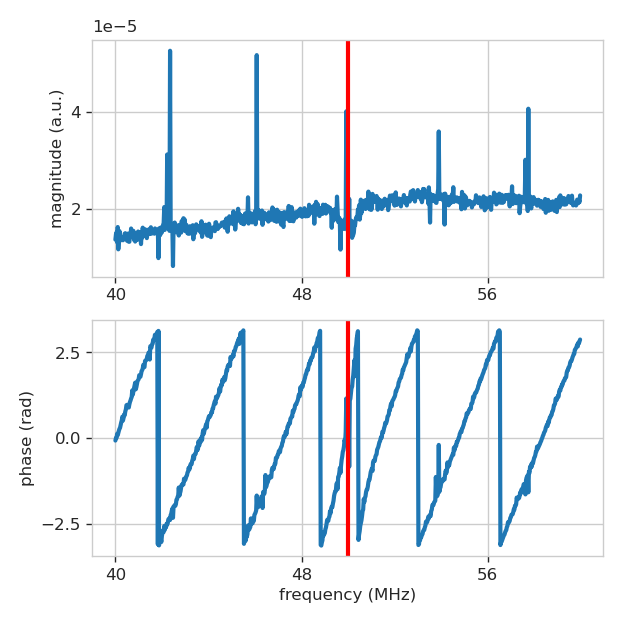

In [45]:
with DatasetAnalysis(data_loc) as analysis:
    data = analysis.get_data('signal', avg_over='repetition')
    f = data.data_vals('ssb_frequency')
    sig = data.data_vals('signal')    
    
    fig = analysis.make_figure('SSB signal', figsize=(3,3))
    
    # first subfig: magnitude
    ax = fig.add_subplot(211)
    ax.plot(f*1e-6, np.abs(sig))
    ax.axvline(params.readout.IF()*1e-6, color='r')
    format_ax(ax, ylabel='magnitude (a.u.)')
    
    ax = fig.add_subplot(212, sharex=ax)
    ax.plot(f*1e-6, np.angle(sig, deg=False))
    ax.axvline(params.readout.IF()*1e-6, color='r')
    format_ax(ax, xlabel='frequency (MHz)', ylabel='phase (rad)')
    
    # this command saves the figures associated with the analysis in the data folder.
    # analysis.save()

## Pulsed resonator spectroscopy as a function of power

In [ ]:
setup_qubit_measurement_defaults(repetition_delay=10_000)

single_transmon.options.readout_pulse = 'readout_short'
single_transmon.measure_qubit = single_transmon.measure_full_integration

measurement = single_transmon.pulsed_resonator_spec(
    start=40e6,
    stop=60e6,
    step=0.025e6,
    n_reps=100,
    collector_options=dict(batchsize=100),
)

sweep = sweep_parameter(params.readout.short.amp, np.linspace(0.01, 0.05, 10)) \
        @ measurement
data_loc, _ = run_measurement(sweep=sweep, name='pulsed_resonator_spec_vs_pwr')

## Qubit spec (saturation)

In [ ]:
setup_qubit_measurement_defaults()

measurement = single_transmon.qubit_ssb_spec_saturation(
    start=50e6,
    stop=150e6,
    step=0.1e6,
    n_reps=100,
    collector_options=dict(batchsize=100)
)

data_loc, _ = run_measurement(sweep=measurement, name=f'qubit_ssb_saturation_spec')

## Qubit spec (pi)

In [5]:
setup_qubit_measurement_defaults()

# automatically try to do spec around the center
center = params.qubit.IF()

# dynamically make a weaker pipulse to narrow the line
weaken_by = 5
amplitude = 1. / weaken_by
duration = params.qubit.drive.pipulse.nsigmas() * params.qubit.drive.pipulse.sigma() * weaken_by // 4


# run the measurement
measurement = single_transmon.qubit_ssb_spec_pi(
    start=center-5e6,
    stop=center+5e6,
    step=0.1e6,
    amplitude=amplitude,
    duration=duration,
    n_reps=100,
    collector_options=dict(batchsize=100)
)
data_loc, _ = run_measurement(sweep=measurement, name='qubit_ssb_spec_pi')

[2022-12-05 09:51:38.787] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T095138_b465ef56-qubit_ssb_spec_pi/data.ddh5
[2022-12-05 09:51:38.840] [qm: INFO] Performing health check
[2022-12-05 09:51:38.843] [qm: INFO] Health check passed
[2022-12-05 09:51:38.860] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 09:51:38.869] [qm: INFO] Performing health check
[2022-12-05 09:51:38.872] [qm: INFO] Health check passed
[2022-12-05 09:51:39.214] [qm: INFO] Flags: 
[2022-12-05 09:51:39.214] [qm: INFO] Sending program to QOP
[2022-12-05 09:51:39.671] [qm: INFO] Executing program
[2022-12-05 09:51:44.973] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.
[2022-12-05 09:51:44.977] [root: INFO] 
Saved data at /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T095138_b465ef56-

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 100
    # variables        = 4
    chi-square         = 6.6390e-11
    reduced chi-square = 6.9156e-13
    Akaike info crit   = -2796.06502
    Bayesian info crit = -2785.64434
[[Variables]]
    x0:     1.7395e+08 +/- 13771.5996 (0.01%) (init = 1.739e+08)
    sigma:  412737.870 +/- 14402.5321 (3.49%) (init = 495000)
    A:     -1.3032e-05 +/- 3.8240e-07 (2.93%) (init = -1.179549e-05)
    of:     1.2519e-05 +/- 9.4128e-08 (0.75%) (init = 1.117075e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, A)  = 0.493
    C(sigma, of) = 0.293
    C(A, of)     = -0.174
[2022-12-05 10:23:19.903] [root: INFO] updated qubit IF frequency to 173950814.28219295


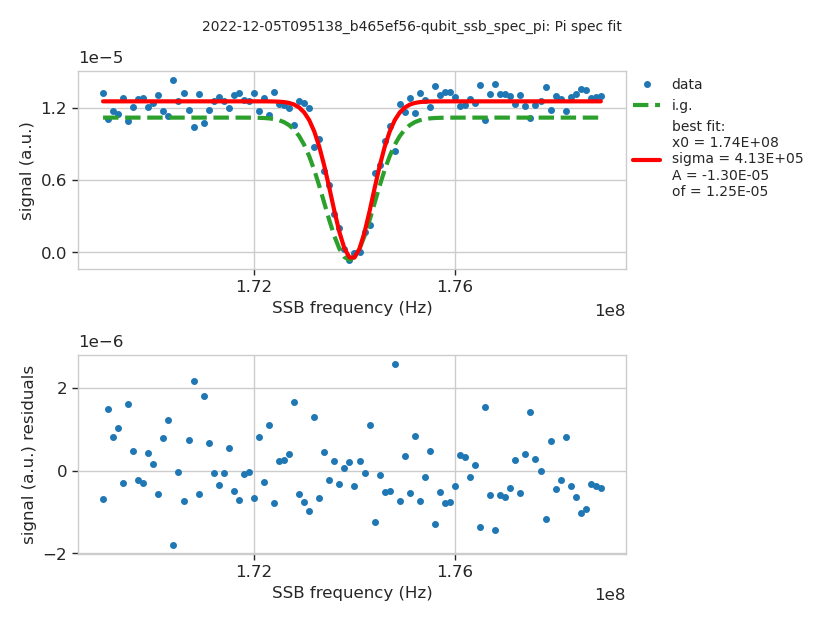

In [5]:
from qcuiuc_measurement.analysis.common_fits import Gaussian

with DatasetAnalysis(data_loc) as analysis:
    data = analysis.get_data('signal', avg_over='repetition')
    f = data.data_vals('ssb_frequency')
    sig = data.data_vals('signal').real
    
    fig = analysis.make_figure('Pi spec fit', figsize=(4,3))
    _, fitres = plot_data_and_fit_1d(
        f, sig, fit_class=Gaussian,
        fig=fig, 
        initial_guess=True,  # enable this if the guess goes wrong to see why...
        xlabel='SSB frequency (Hz)', 
        ylabel='signal (a.u.)',
    )
    # TODO: save the fit report to a file as well...
    
    # set the corrected SSB frequency to the parameter manager
    new_f0 = fitres.params['x0'].value
    params.qubit.IF(new_f0)
    logger.info(f'updated qubit IF frequency to {new_f0}')

    analysis.save()

# Qubit tune-up operations

## Power Rabi and pi-pulse calibration

In [46]:
setup_qubit_measurement_defaults()

measurement = single_transmon.qubit_power_rabi(
    start=-1.9,
    stop=1.9,
    step=0.1,
    n_reps=100,
    collector_options=dict(batchsize=100)
)
data_loc, _ = run_measurement(sweep=measurement, name='power_rabi')

[2022-12-05 16:12:47.530] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T161247_f33b2a36-power_rabi/data.ddh5
[2022-12-05 16:12:47.596] [qm: INFO] Performing health check
[2022-12-05 16:12:47.598] [qm: INFO] Health check passed
[2022-12-05 16:12:47.614] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 16:12:47.622] [qm: INFO] Performing health check
[2022-12-05 16:12:47.624] [qm: INFO] Health check passed
[2022-12-05 16:12:47.894] [qm: INFO] Flags: 
[2022-12-05 16:12:47.895] [qm: INFO] Sending program to QOP
[2022-12-05 16:12:47.953] [qm: INFO] Executing program
[2022-12-05 16:12:50.424] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.
[2022-12-05 16:12:50.434] [root: INFO] 
Saved data at /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T161247_f33b2a36-power_r

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 38
    # variables        = 3
    chi-square         = 1.5934e-11
    reduced chi-square = 4.5527e-13
    Akaike info crit   = -1077.00479
    Bayesian info crit = -1072.09203
[[Variables]]
    A:   -6.1758e-06 +/- 1.6145e-07 (2.61%) (init = 6.489716e-06)
    of:   8.7733e-06 +/- 1.1980e-07 (1.37%) (init = 9.115889e-06)
    phi:  0 (fixed)
    f:    0.49792511 +/- 0.00377657 (0.76%) (init = 0.5263158)
[[Correlations]] (unreported correlations are < 0.100)
    C(of, f) = 0.400
    C(A, f)  = 0.158
    C(A, of) = 0.136
[2022-12-05 16:12:52.581] [root: INFO] updated pi amp from 0.026566260807652134 to 0.026676964555142905


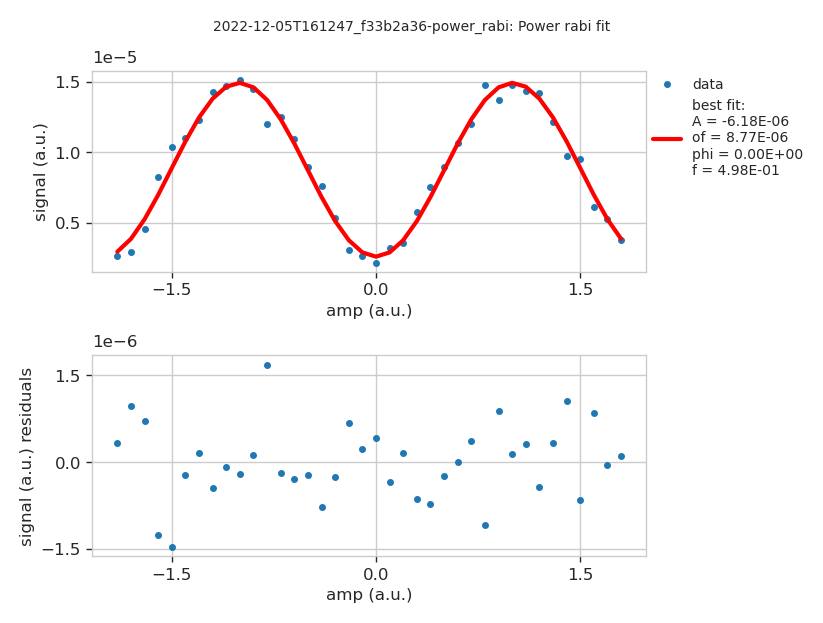

In [47]:
from qcuiuc_measurement.analysis.common_fits import Cosine

with DatasetAnalysis(data_loc) as analysis:
    data = analysis.get_data('signal', avg_over='repetition')
    amp = data.data_vals('amplitude')
    sig = data.data_vals('signal').real
    
    # fix the phase, since we measure with positive and negative amplitude
    phi = Parameter(name='phi', value=0, vary=False)
    
    fig = analysis.make_figure('Power rabi fit', figsize=(4,3))
    _, fitres = plot_data_and_fit_1d(amp, sig, fit_class=Cosine, 
                                              fig=fig, 
                                              # initial_guess=True,  # enable this if the guess goes wrong to see why...
                                              phi=phi,
                                              xlabel='amp (a.u.)', 
                                              ylabel='signal (a.u.)',
                                              )
    # TODO: save the fit report to a file as well...
    
    # calculate correction for the pi-pulse amplitude
    # and set the corrected value to the parameter manager
    old_pi_amp = analysis.load_saved_parameter('qubit.drive.pipulse.amp')
    correction = 0.5 / fitres.params['f'].value
    params.qubit.drive.pipulse.amp(old_pi_amp * correction)
    logger.info(f'updated pi amp from {old_pi_amp} to {old_pi_amp * correction}')
    
    analysis.save()

# Qubit characterization

## Qubit T1

In [21]:
setup_qubit_measurement_defaults()

measurement = single_transmon.qubit_T1(
    start=20,
    stop=20+100e3,
    step=1000,
    n_reps=100,
    collector_options=dict(batchsize=100)
)

data_loc, _ = run_measurement(sweep=measurement, name='qubit_T1')

[2022-12-05 10:53:11.457] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T105311_4d66ce70-qubit_T1/data.ddh5
[2022-12-05 10:53:11.509] [qm: INFO] Performing health check
[2022-12-05 10:53:11.513] [qm: INFO] Health check passed
[2022-12-05 10:53:11.529] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 10:53:11.540] [qm: INFO] Performing health check
[2022-12-05 10:53:11.542] [qm: INFO] Health check passed
[2022-12-05 10:53:11.880] [qm: INFO] Flags: 
[2022-12-05 10:53:11.881] [qm: INFO] Sending program to QOP
[2022-12-05 10:53:12.288] [qm: INFO] Executing program
[2022-12-05 10:53:18.074] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.
[2022-12-05 10:53:18.077] [root: INFO] 
Saved data at /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T105311_4d66ce70-qubit_T1:

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 100
    # variables        = 3
    chi-square         = 7.3283e-11
    reduced chi-square = 7.5549e-13
    Akaike info crit   = -2788.18632
    Bayesian info crit = -2780.37081
[[Variables]]
    A:   -1.2255e-05 +/- 3.7303e-07 (3.04%) (init = -1.426641e-05)
    of:   1.2468e-05 +/- 1.7012e-07 (1.36%) (init = 1.259413e-05)
    tau:  19.9773626 +/- 1.33714135 (6.69%) (init = 15.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(of, tau) = 0.754
    C(A, tau)  = 0.380


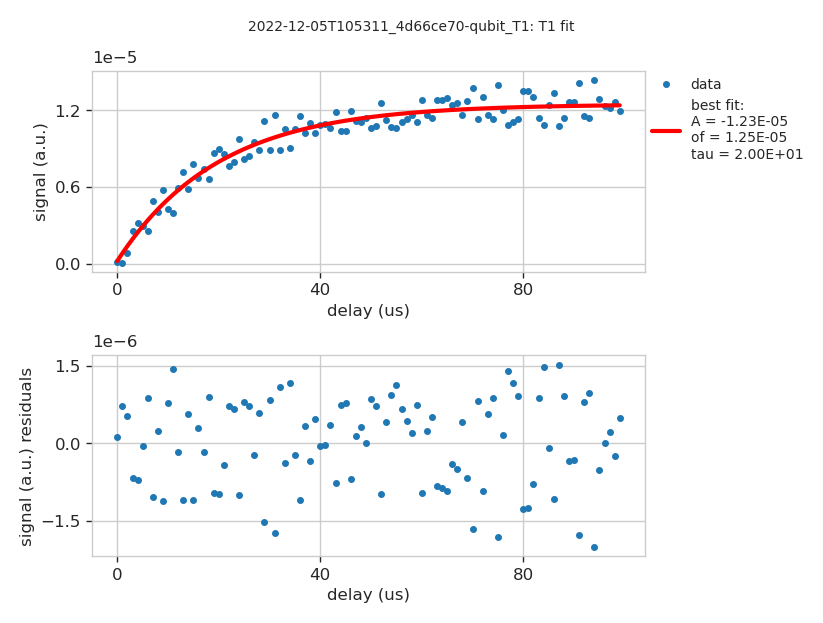

In [22]:
from qcuiuc_measurement.analysis.common_fits import ExponentialDecay

with DatasetAnalysis(data_loc) as analysis:
    data = analysis.get_data('signal', avg_over='repetition')
    delay = data.data_vals('delay') * 1e-3
    sig = data.data_vals('signal').real
    
    fig = analysis.make_figure('T1 fit', figsize=(4,3))
    _, fitres = plot_data_and_fit_1d(
        delay, sig, fit_class=ExponentialDecay, 
        fig=fig, 
        # initial_guess=True,  # enable this if the guess goes wrong to see why...
        xlabel='delay (us)', 
        ylabel='signal (a.u.)',
    )
    # TODO: save the fit report to a file as well...
    
    analysis.save()

## Qubit T2

In [27]:
setup_qubit_measurement_defaults()

n_echos = 1
step = 200
period = 12 * step
detuning = 1./period * 1e3

measurement = single_transmon.qubit_T2(
    start=20,
    stop=20+(40e3//(n_echos + 1)),
    step=step,
    n_reps=100,
    detuning_MHz=detuning,
    n_echos=n_echos,
    collector_options=dict(batchsize=100)
)

data_loc, _ = run_measurement(sweep=measurement, name=f'qubit_T2-{n_echos}_Echo_{detuning:.2f}MHz_detuned')

[2022-12-05 12:42:22.832] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T124222_8e532cee-qubit_T2-1_Echo_0.42MHz_detuned/data.ddh5
[2022-12-05 12:42:22.891] [qm: INFO] Performing health check
[2022-12-05 12:42:22.894] [qm: INFO] Health check passed
[2022-12-05 12:42:22.908] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-05 12:42:22.916] [qm: INFO] Performing health check
[2022-12-05 12:42:22.920] [qm: INFO] Health check passed
[2022-12-05 12:42:23.225] [qm: INFO] Flags: 
[2022-12-05 12:42:23.225] [qm: INFO] Sending program to QOP
[2022-12-05 12:42:23.375] [qm: INFO] Executing program
[2022-12-05 12:42:29.238] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.
[2022-12-05 12:42:29.241] [root: INFO] 
Saved data at /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-05/2022-12-05T12

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 162
    # data points      = 100
    # variables        = 5
    chi-square         = 8.5925e-11
    reduced chi-square = 9.0447e-13
    Akaike info crit   = -2768.27165
    Bayesian info crit = -2755.24580
[[Variables]]
    A:   -6.3807e-06 +/- 3.7114e-07 (5.82%) (init = -6.018747e-06)
    of:   6.2250e-06 +/- 9.5360e-08 (1.53%) (init = 6.170345e-06)
    phi:  88.3274493 +/- 3.47371810 (3.93%) (init = -37.78915)
    f:    0.20879616 +/- 6.9269e-04 (0.33%) (init = 0.35)
    tau:  23.8581666 +/- 2.43607959 (10.21%) (init = 20.04)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, f) = -0.760
    C(A, tau) = 0.745


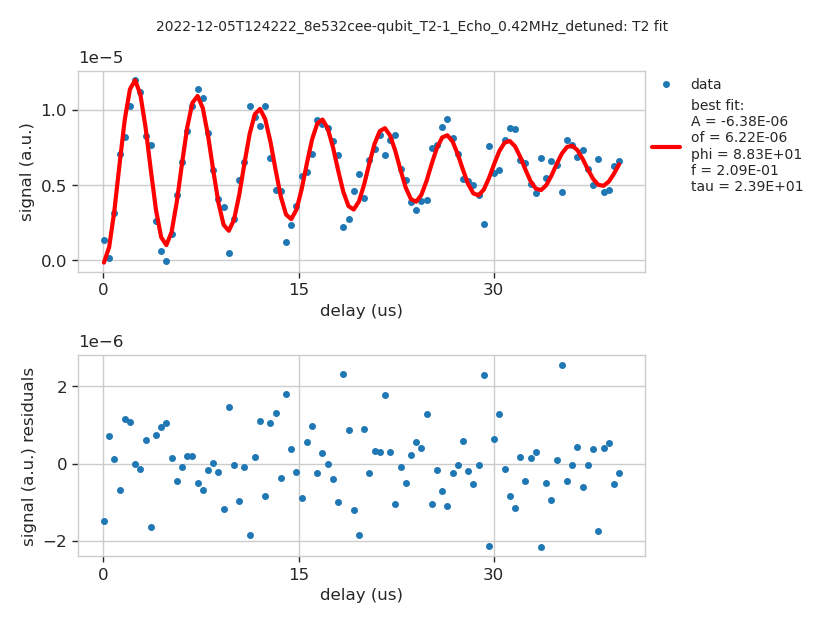

In [28]:
from qcuiuc_measurement.analysis.common_fits import ExponentiallyDecayingSine

with DatasetAnalysis(data_loc) as analysis:
    data = analysis.get_data('signal', avg_over='repetition')
    delay = data.data_vals('delay') * 1e-3
    sig = data.data_vals('signal').real
    
    fig = analysis.make_figure('T2 fit', figsize=(4,3))
    _, fitres = plot_data_and_fit_1d(
        delay, sig, fit_class=ExponentiallyDecayingSine, 
        fig=fig, 
        # initial_guess=True,  # enable this if the guess goes wrong to see why...
        xlabel='delay (us)', 
        ylabel='signal (a.u.)',
    )
    # TODO: save the fit report to a file as well...
    
    analysis.save()